# Univariate TVS Regression

In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [38]:
# Change to the root directory
os.chdir("../")

# Import custom functions
from src.model.linearObjective import linearTauSolver
from src.model.linearTVSR import linearTVSRModel
import src.support as src

## Create Simulated data

For this example we define a simulated time series with linear form, y = A*x_i + C + e.

The arbitrary values of the the parameters are:
- A is the linear coefficient, and is set to 2
- C is a constant, set to 6.5
- e is random noise and is randomly drawn from N~(0,0.2)

In [39]:
# First we define effect size variable
A = np.array(2, dtype="float")
C = 6.5

We simulate a random series x(t), which represents the observed value of the input.

The series x(t) is assumed to have the following properties:
- x(t) should be stationary
- The effect, f(x(t)) must have a known value of zero. In other words, we know when the system input is 'off'
- Discrete time input with a finite number of impulses. An impulse is defined to be where f(x(t) != 0. 


In [40]:
# Create the Input signal x(t)
np.random.seed(17)
x = src.create_input(100, 0.2, binary=False)

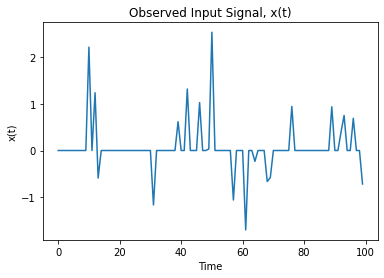

In [41]:
plt.plot(x)
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.title("Observed Input Signal, x(t)")
plt.show()

However, due to some unknown process in our systen, there are random errors in the time domain for our variable x. In other words, after the input is provided to the system, there is a random time delay for each input impulse.

The true series (in terms of causing effects) is therefore x_i, where x_i = X(t + Tau). X(t + Tau) represents the decomposed matrix form of x(t), where each row represents a single impulse, shifted by some time delay (tau).

In [42]:
# Decompose the series x(t) into its matrix X(t)
X, bounds = src.decompose_vector(x, return_bounds=True)

The cell below shows the first three rows of the X(t) matrix, corresponding to the first 3 spikes in the diagram above.

In [43]:
print(np.round(X[:3,0:14],1))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.2  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.2  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.6]]


Now we generate a random set of time delays (taus) and apply these to each row of the X(t) matrix. For the sake of example, the delays are drawn from a Normal distribution N~(0,2).

In [44]:
# Generate a random shift seq
np.random.seed(15)
real_shifts = np.round(np.random.randn(X.shape[0])*2)
real_shifts = np.array(real_shifts, dtype="int")

In [45]:
real_shifts

array([-1,  1,  0, -1,  0, -4, -2, -2, -1, -1,  0,  1,  1,  1, -1,  1,  0,
        3,  1,  0])

(array([1., 0., 2., 0., 5., 5., 0., 6., 0., 1.]),
 array([-4. , -3.3, -2.6, -1.9, -1.2, -0.5,  0.2,  0.9,  1.6,  2.3,  3. ]),
 <BarContainer object of 10 artists>)

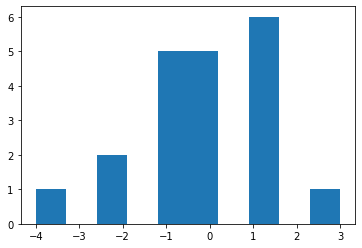

In [46]:
plt.hist(real_shifts)

Now we apply the shifts to the X(t) matrix, to produce X(t + Tau)

In [47]:
# Shift the series
X_shift = src.shift_array(X, np.array(real_shifts, dtype="int"))
X_shift = src.hor_mul(X_shift, A)

And then we create the simulated output y = A*x_i + C + e

In [48]:
# Retrieve the observed series, only for reference.
xi = np.sum(src.shift_array(X, np.array(real_shifts, dtype="int")), axis=0)
y = np.sum(X_shift, axis=0) + np.random.randn(X_shift.shape[1])*0.2 + C

### Plot the Simulated Series

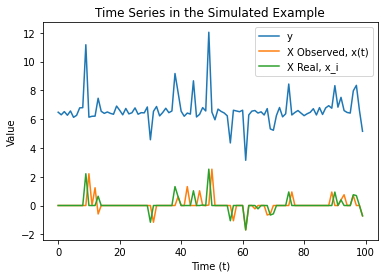

In [49]:
# Plot the sequences
plt.plot(y)
plt.plot(x)
plt.plot(xi)
plt.xlabel("Time (t)")
plt.ylabel("Value")
plt.title("Time Series in the Simulated Example")
plt.legend(["y","X Observed, x(t)","X Real, x_i"])
plt.show()

## Modelling

### Instantiate a model with default parameters

In [50]:
#TVS Regression - initialise a model
tvs = linearTVSRModel()

### Fit Model

Fit the model with the tvs regression class. The TVS Regression tries to find the maximum likelihood estimate of both the y-axis error (e) and the time delay errors (Tau). It does this via an inner optimisation of the Tau distribution and an outer optimisation of the regression parameters. Detailed information can be found in the paper.

Inner optimisation is taken care of by the custom tau optimiser module, written specifically for the purpose. In principle, the outer optimisation could be handled by a number of existing suitable methods. Due to the inner tau optimisation, the outer optimisation has a rough (bumpy) solution space. In addition, there can exist local maxima eg. for example where the value of the taus all = 0. For these reasons we have chosen differential evolution (from the scipy.optimize library). This seems to provide a good balance between exploration and greedy local searches. With some basic settings, fitting takes a few minutes. Comment the line "%%capture", if you would like to follow the progress.

In [51]:
tvs.fit(x, y, method="differential_evolution", split=False)

Epoch:  1
Likelihood: 56.293
Epoch:  2
Likelihood: 7862.515
Epoch:  3
Likelihood: 3033.871
Epoch:  4
Likelihood: 193.788
Epoch:  5
Likelihood: 85.946
Epoch:  6
Likelihood: 124.308
Epoch:  7
Likelihood: 220.063
Epoch:  8
Likelihood: 39.481
Epoch:  9
Likelihood: 70.755
Epoch:  10
Likelihood: 88.448
Epoch:  11
Likelihood: 107.825
Epoch:  12
Likelihood: 95.361
Epoch:  13
Likelihood: 62.53
Epoch:  14
Likelihood: 444.262
Epoch:  15


/Users/aaronpickering/Desktop/projects/cronus/src/support.py:85: RuntimeWarning: divide by zero encountered in log
  l = np.log(norm.pdf(x,loc=u, scale=sd))


Likelihood: 27598.106
Epoch:  16
Likelihood: 338.525
Epoch:  17
Likelihood: 120.848
Epoch:  18
Likelihood: 4940.107
Epoch:  19
Likelihood: 154.806
Epoch:  20
Likelihood: 178.526
Epoch:  21
Likelihood: 810.298
Epoch:  22
Likelihood: 444.944
Epoch:  23
Likelihood: 65.877
Epoch:  24
Likelihood: 73.198
Epoch:  25
Likelihood: 138.536
Epoch:  26
Likelihood: 132.93
Epoch:  27
Likelihood: 133.138
Epoch:  28
Likelihood: 96.799
Epoch:  29
Likelihood: 93.499
Epoch:  30
Likelihood: 203.046
Epoch:  31
Likelihood: 39.509
Epoch:  32
Likelihood: 171.499
Epoch:  33
Likelihood: 159.842
Epoch:  34
Likelihood: 96.197
Epoch:  35
Likelihood: 244.888
Epoch:  36
Likelihood: 1765.527
Epoch:  37
Likelihood: 125.329
Epoch:  38
Likelihood: 71.205
Epoch:  39
Likelihood: 661.028
Epoch:  40
Likelihood: 51.791
Epoch:  41
Likelihood: 58.453
Epoch:  42
Likelihood: 52.293
Epoch:  43
Likelihood: 64.426
Epoch:  44
Likelihood: 65.4
Epoch:  45
Likelihood: 94.497
Epoch:  46
Likelihood: 31.519
Epoch:  47
Likelihood: 113.513
E

Likelihood: 2.823
Epoch:  281
Likelihood: -31.98
Epoch:  282
Likelihood: -26.228
Epoch:  283
Likelihood: inf
Epoch:  284
Likelihood: -46.807
Epoch:  285
Likelihood: -64.682
Epoch:  286
Likelihood: -39.575
Epoch:  287
Likelihood: 54.753
Epoch:  288
Likelihood: 18.026
Epoch:  289
Likelihood: -46.342
Epoch:  290
Likelihood: -89.197
Epoch:  291
Likelihood: 113.09
Epoch:  292
Likelihood: 112.258
Epoch:  293
Likelihood: -22.439
Epoch:  294
Likelihood: inf
Epoch:  295
Likelihood: -36.591
Epoch:  296
Likelihood: 93.993
Epoch:  297
Likelihood: 68.32
Epoch:  298
Likelihood: 95.841
Epoch:  299
Likelihood: -127.2
Epoch:  300
Likelihood: -69.629
Epoch:  301
Likelihood: 64.146
Epoch:  302
Likelihood: 235.519
Epoch:  303
Likelihood: -125.265
Epoch:  304
Likelihood: 2903.032
Epoch:  305
Likelihood: -15.132
Epoch:  306
Likelihood: 842.679
Epoch:  307
Likelihood: -22.183
Epoch:  308
Likelihood: -56.778
Epoch:  309
Likelihood: -52.848
Epoch:  310
Likelihood: inf
Epoch:  311
Likelihood: 2311.756
Epoch:  3

Likelihood: -116.526
Epoch:  541
Likelihood: -124.542
Epoch:  542
Likelihood: 129.21
Epoch:  543
Likelihood: -133.135
Epoch:  544
Likelihood: -121.341
Epoch:  545
Likelihood: inf
Epoch:  546
Likelihood: -113.033
Epoch:  547
Likelihood: -113.92
Epoch:  548
Likelihood: 651.898
Epoch:  549
Likelihood: 30.774
Epoch:  550
Likelihood: -12.222
Epoch:  551
Likelihood: 64.686
Epoch:  552
Likelihood: -72.816
Epoch:  553
Likelihood: -125.605
Epoch:  554
Likelihood: 103.164
Epoch:  555
Likelihood: -92.899
Epoch:  556
Likelihood: -91.734
Epoch:  557
Likelihood: 8.318
Epoch:  558
Likelihood: inf
Epoch:  559
Likelihood: -101.93
Epoch:  560
Likelihood: 917.771
Epoch:  561
Likelihood: -120.933
Epoch:  562
Likelihood: 29.841
Epoch:  563
Likelihood: -90.8
Epoch:  564
Likelihood: 105.778
Epoch:  565
Likelihood: -149.262
Epoch:  566
Likelihood: 312.728
Epoch:  567
Likelihood: 49.376
Epoch:  568
Likelihood: 71.49
Epoch:  569
Likelihood: -81.713
Epoch:  570
Likelihood: -82.102
Epoch:  571
Likelihood: -111.97

Likelihood: -100.899
Epoch:  799
Likelihood: -86.896
Epoch:  800
Likelihood: 551.536
Epoch:  801
Likelihood: -72.92
Epoch:  802
Likelihood: -134.481
Epoch:  803
Likelihood: -115.034
Epoch:  804
Likelihood: -86.574
Epoch:  805
Likelihood: -125.508
Epoch:  806
Likelihood: -142.196
Epoch:  807
Likelihood: -3.512
Epoch:  808
Likelihood: -160.322
Epoch:  809
Likelihood: -138.188
Epoch:  810
Likelihood: -167.481
Epoch:  811
Likelihood: -136.786
Epoch:  812
Likelihood: -117.103
Epoch:  813
Likelihood: -140.815
Epoch:  814
Likelihood: -91.9
Epoch:  815
Likelihood: -164.294
Epoch:  816
Likelihood: -68.835
Epoch:  817
Likelihood: -130.991
Epoch:  818
Likelihood: -137.052
Epoch:  819
Likelihood: -149.757
Epoch:  820
Likelihood: -124.856
Epoch:  821
Likelihood: -128.231
Epoch:  822
Likelihood: -155.749
Epoch:  823
Likelihood: -133.278
Epoch:  824
Likelihood: -116.506
Epoch:  825
Likelihood: -129.051
Epoch:  826
Likelihood: -130.063
Epoch:  827
Likelihood: -85.096
Epoch:  828
Likelihood: -145.161
E

/Users/aaronpickering/opt/miniconda3/envs/cronus/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Likelihood: inf
Epoch:  854
Likelihood: inf
Epoch:  855
Likelihood: inf
Epoch:  856
Likelihood: -189.638
Epoch:  857
Likelihood: -121.492
Epoch:  858
Likelihood: -98.438
Epoch:  859
Likelihood: -143.988
Epoch:  860
Likelihood: -136.761
Epoch:  861
Epoch:  862
Epoch:  863
Epoch:  864
Epoch:  865
Epoch:  866
Likelihood: inf
Epoch:  867
Likelihood: inf
Epoch:  868
Likelihood: inf
Epoch:  869
Likelihood: inf
Epoch:  870
Likelihood: inf
Epoch:  871
Likelihood: -172.754
Epoch:  872
Likelihood: -117.549
Epoch:  873
Likelihood: -189.86
Epoch:  874
Likelihood: -147.432
Epoch:  875
Likelihood: -143.448


### Results

In [52]:
# Print the summary
tvs.summary

     fun: -182.67485058731944
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 875
     nit: 20
 success: False
       x: array([2.02422485, 2.17191539, 0.27231543, 6.51003676])

Estimated Beta value: 2.02
<br>
Estimated Constant: 6.51
<br>
Estimated Tau SD: 2.17
<br>
Estimated Error: 0.27
<br>


[-0.36234905 -0.29002864  0.95251472  0.04393761  1.36675798 -0.07736436
 -0.16533904  5.53907947 -0.00738509  0.11931733 -3.35764439  0.10047828
  0.23331648 -1.17660165 -0.20959441  0.25980424  1.01452664  0.09636048
  1.47062865 -1.34315159]
[ 2.20701631  1.2335289  -0.58788084 -1.16304859  0.61521962  1.31351616
  1.02362483  0.03260213  2.52525474 -1.05763265 -1.69571592 -0.23165547
 -0.66184754 -0.57916852  0.94135926  0.93386985  0.3918059   0.74832175
  0.6884956  -0.71571126]


In [70]:
# Estimated best shift sequences (taus.)
tvs.shift_seq

array([-1,  1,  0, -1,  0, -4, -2,  0, -1, -1,  0,  1,  1,  1, -1,  1,  0,
        4,  0,  0])

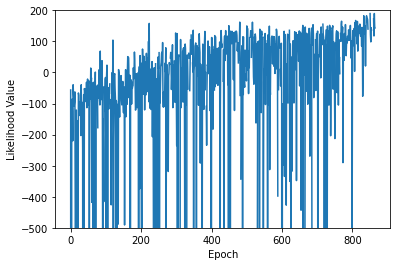

In [80]:
# Plot the fit history
#tvs.history = tvs.history.reset_index()
plt.plot(tvs.history['likelihood'])
plt.ylim(-500,200)
plt.ylabel("Likelihood Value")
plt.xlabel("Epoch")
plt.show()

In [81]:
# Predict (fit)
f = linearTauSolver(X, y, tvs.summary.x[0], 0, tvs.summary.x[1], 0, tvs.summary.x[2], tvs.summary.x[3])

# Create a prediction
y_p = f.predict(tvs.shift_seq)

TypeError: __init__() missing 1 required positional argument: 'family'

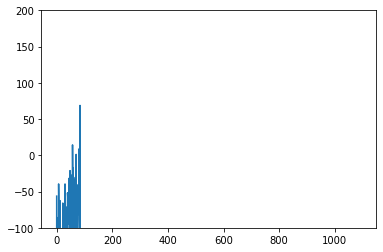

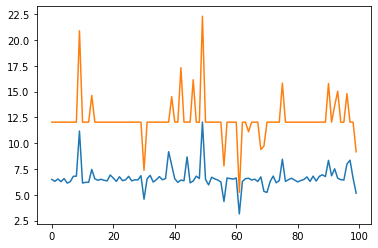

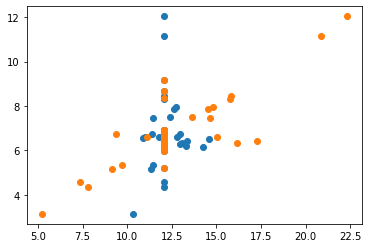

In [53]:











# Plot the sequences
plt.plot(y)
plt.plot(y_p)
plt.show()

# Scatter Plots
plt.scatter(x + tvs.summary.x[3], y)
plt.scatter(y_p, y)
plt.show()
